In [3]:

from scipy import stats, histogram, signal
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from math import log
import itertools
#import bokeh
from bokeh.charts import HeatMap, Histogram, output_file, show
from bokeh.io import output_notebook, show

%matplotlib inline

In [4]:
input = 'NAMSAM_Total_GEM_2014_2017_Public_8_8_17.txt'
outdict = {}
cleandict = {}


In [5]:
# !pip install seaborn --user

In [6]:
#output_notebook()

In [7]:
def dfheatmap(frame):
    hm = HeatMap(frame)
    show(hm)
    

In [8]:
def list2kernel(bins, list, plot=False):
    #mini = min(min(mi) for mi in list if mi)
    #maxi = max(max(ma) for ma in list if ma)
    
    mini = np.nanmin(list)
    maxi = np.nanmax(list)
    hh,loc = np.histogram(list, range=(mini, maxi), bins=bins)
    kernel = stats.norm.pdf((loc[1:]+loc[:-1]), 0, 0.1)
    #gaus = stats.gaussian_kde(list)
    kde = signal.fftconvolve(hh, kernel, 'same')
    if plot:
        #fig = plt.figure(figsize=(10,10))
    
        #plt.subplot(1,1,1)
        plt.plot((loc[1:]+loc[:-1]), kde, linewidth=0.5)
    
    
    
        
    return kernel

In [9]:
%%time
# extract sample list from first line of GEM.  Excludes first field 'TranscriptID'
count = 0
for line in open(input):
    count += 1
    if count == 1:
        samples = line.strip().split('\t')[1:]
        break

        
master_dtype = {}
master_dtype['TranscriptID'] = 'str'
for item in samples:
    master_dtype[item] = 'float32'
        
# load GEM into data frame, replace 0 with NaN
master = pd.read_table(input, dtype=master_dtype, na_values=0)
#master[master==0] = np.nan

# load aggregate distribution, log transform, convert to single list
aggregate = np.log(master[samples]).values.tolist()
merged = list(itertools.chain.from_iterable(aggregate))

#pd.DataFrame.hist(aggregate, column='SRR1174218', xlabelsize=0.1, ylabelsize=0.1)
#master = pd.read_table(input, index_col=0, dtype=np.float64)



CPU times: user 5.01 s, sys: 471 ms, total: 5.48 s
Wall time: 5.55 s


In [12]:
#dfheatmap(master)

In [13]:
master.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47205 entries, Sobic.001G000100.1.v3.1 to Sobic.K044505.1.v3.1
Columns: 302 entries, SRR5488075 to 140926HiSeq_Run_Sample_PI329311_A__CLEM_Saski_ACAGTG_L002_R1_001.fastq.gz
dtypes: float32(301), float64(1)
memory usage: 54.9+ MB


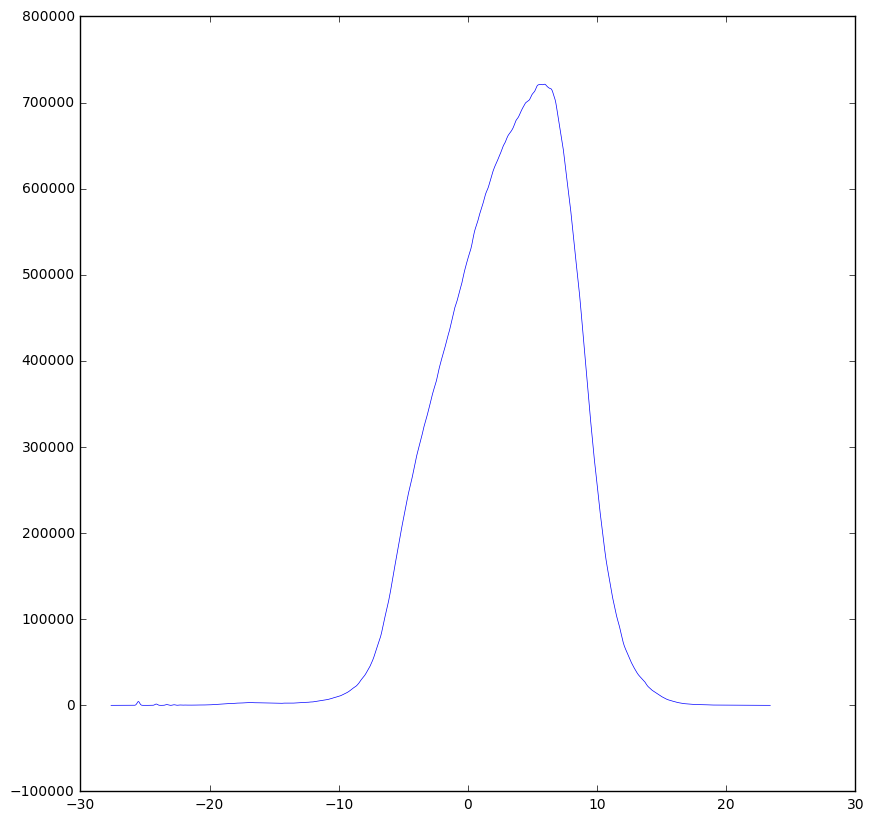

In [14]:
plt.figure(1, figsize=(10,10))
ref = list2kernel(10000, merged, True)
plt.show()
plt.clf()
plt.close()
#ex = np.log(pd.DataFrame(master['90-merged_counts.fpkm'])).values.tolist()
#flt = list(itertools.chain.from_iterable(exp))
#temp = list2kernel(10000, flt, True )


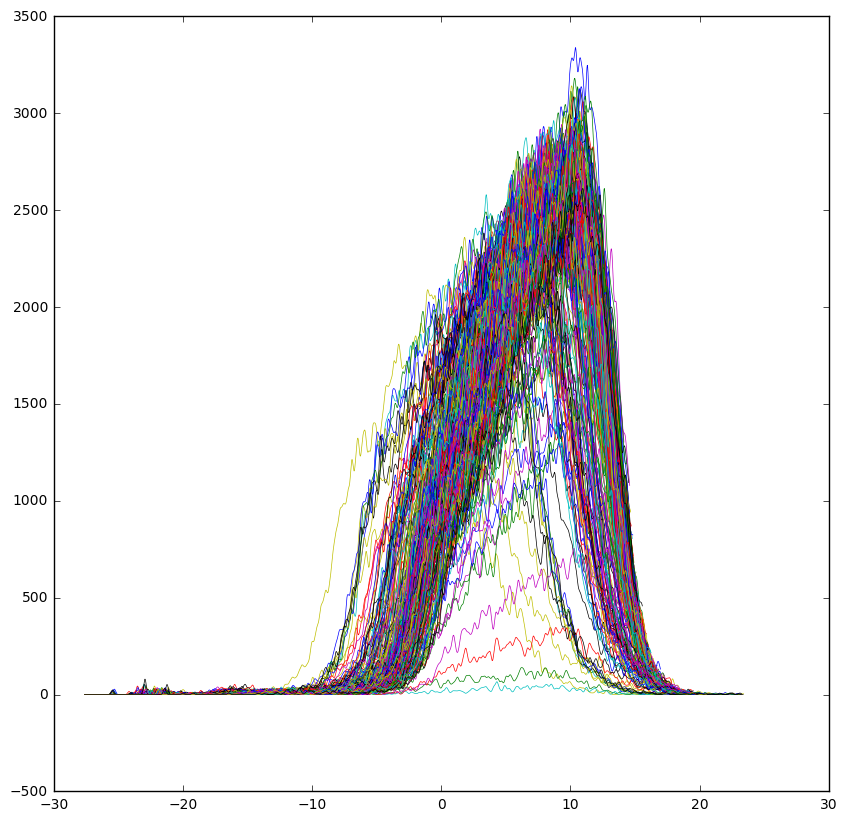

Outlier sample results
30F.fastq.gz	0.0312	0.00011452132029
68F.fastq.gz	0.0289	0.000458434579122
55F.fastq.gz	0.0352	7.96949822811e-06
25F.fastq.gz	0.0281	0.000724431148253
SRR5488087	0.03	0.000239292853238
SRR5493599	0.0278	0.000857193594341
DRR059877	0.0316	8.90053617997e-05
Sample_Feltus4_L006_R1.cat.fastq.gz	0.0278	0.000857193594341
SRR5488078	0.0376	1.38044967805e-06
SRR5488098	0.0276	0.000957997397213
140304HiSeq_Run_Saski_Sample_IEOTI_2_3_GCCAAT_L007_R1_001.fastq.gz	0.0289	0.000458434579122
Sample_Feltus3_L007_R1.cat.fastq.gz	0.0302	0.000212060969357
20F.fastq.gz	0.0407	1.20845403913e-07
SRR3682668	0.0291	0.000408061718211
140926HiSeq_Run_Sample_PI562730_A__CLEM_Saski_CAGATC_L001_R1_001.fastq.gz	0.0294	0.000342172339125
21F.fastq.gz	0.0306	0.000166141021857
SRR5493580	0.0276	0.000957997397213
SRR5488083	0.0289	0.000458434579122
3F.fastq.gz	0.0306	0.000166141021857
140926HiSeq_Run_Sample_PI297130_A__CLEM_Saski_TGACCA_L001_R1_001.fastq.gz	0.0301	0.000225288391396
76F.fastq.gz	0.0

In [15]:
plt.figure(2, figsize=(10,10))
for id in samples:
    
    
    exp = np.log(pd.DataFrame(master[id])).values.tolist()
    flat = list(itertools.chain.from_iterable(exp))
    
    if not np.isnan(flat).all():
        testdist = list2kernel(10000, flat, True) 
        ks = stats.ks_2samp(ref, testdist)
        #ks = stats.ks_2samp(master, flat)
    else:
        print(str('WARNING: Sample' + id + ' is all missing values.  Excluding from analysis'))
    #testdist = expdict[sample]
    
    #ks = stats.ks_2samp(flat, merged)
    count = 0
    #list2kernel(10000, expdict[sample], True)
    #iterate over scipy ks object and separate Dvals from pvals using counter\
    #(Dval is presented before Pval in this object)
    dval, pval = ks

    """
        print(item)
        if count == 0:
            dval = item
            count +=1
            #print(str(dval))
        else:
            pval = item
            count == 0
    """
    # Classify samples as an outlier if the Dval is >= 0.15
    #if dval >= 0.15:
    if pval <= 0.001:
        outdict[id] = [dval, pval]
    else:
        cleandict[id] = [dval, pval]
plt.show()
#plt.savefig("test.png")
plt.clf()
plt.close()

print("Outlier sample results")
for key in outdict:
    print(key + '\t' + str(outdict[key][0]) + '\t' + str(outdict[key][1]))

print("Clean sample results")
for key in cleandict:
    print(key + '\t' + str(cleandict[key][0]) + '\t' + str(cleandict[key][1]))



In [18]:
ks = []
for key in cleandict:
    ks.append(cleandict[key][0])
for key in outdict:
    ks.append(outdict[key][1])

([array([ 4.,  2.,  1.,  0.,  0.,  1.,  0.,  1.,  0.,  1.]),
  array([ 11.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.])],
 array([  0. ,   9.9,  19.8,  29.7,  39.6,  49.5,  59.4,  69.3,  79.2,
         89.1,  99. ]),
 <a list of 2 Lists of Patches objects>)

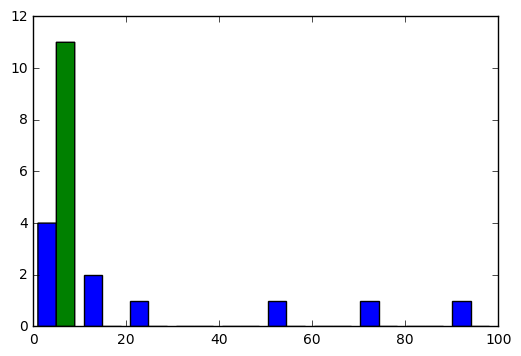

In [19]:
hist = histogram(ks)
plt.hist(hist)